In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from tqdm import tqdm_notebook

In [28]:
data = pd.read_csv('/home/vijjus/datasets/cdc_train.csv')

In [29]:
data.head()

,text,sex,age,event
0,57YOM WITH CONTUSION TO FACE AFTER STRIKING IT...,1,57,62
1,A 45YOM FELL ON ARM WHILE WORKING HAD SLIPPED ...,1,45,42
2,58YOM WITH CERVICAL STRAIN BACK PAIN S P REST...,1,58,26
3,33 YOM LAC TO HAND FROM A RAZOR KNIFE,1,33,60
4,53YOM AT WORK IN A WAREHOUSE DOING UNSPECIFIED...,1,53,71


In [4]:
glove_path="/home/vijjus/glove/glove.6B.50d.txt"
embedding_size=50

In [5]:
# Load embedding matrix and vocab mappings
from vocab import get_glove
emb_matrix, word2id, id2word = get_glove(glove_path, embedding_size)

  1%|          | 2637/400000 [00:00<00:15, 26367.89it/s]

Loading GLoVE vectors from file: /home/vijjus/glove/glove.6B.50d.txt


100%|██████████| 400000/400000 [00:06<00:00, 58953.87it/s]


Text sanitization:

* Convert yom/yof/ym/yo/yf to "year old.."
* Split words that are joined

In [30]:
def do_split(token, output_list):
    if token not in word2id:
        split = -1
        for i in range(1,len(token)):
            if token[:i] in word2id:
                split = i
        if split is not -1:
            sub1 = token[:split]
            sub2 = token[split:]
            if sub1 in word2id:
                output_list.append(sub1)
            if sub2 in word2id:
                output_list.append(sub2)
    else:
        output_list.append(token)
    return output_list

In [31]:
# receive a list of tokens and return a transformed list that has tokens
# present in the embedding dictionary
def process_text(input_list):
    output_list = []
    for tok in input_list:
        output_list = do_split(tok, output_list)
    return output_list

In [32]:
# check for words that are not in the volabulary
def sanitize_data(data):
    total_len = len(data)
    for i in tqdm_notebook(range(total_len)):
        text = data.iloc[i]['text'].lower()
        tokens = text.split(" ")
        tokens = process_text(tokens)
        data.at[i, 'text'] = ' '.join(tokens)

In [33]:
sanitize_data(data)

In [34]:
# check for words that are not in the volabulary
def check_unks(data):
    unknowns = 0
    unknown_words = []
    total_len = len(data)
    for i in tqdm_notebook(range(total_len)):
        text = data.iloc[i]['text'].lower()
        tokens = text.split(" ")
        for j, token in enumerate(tokens):
            if token not in word2id and token not in unknown_words:
                unknown_words.append(token)
                unknowns += 1
    print("{} tokens not in embedding dictionary".format(unknowns))
    return unknown_words

In [35]:
unks = check_unks(data)


0 tokens not in embedding dictionary


In [36]:
data.head()

,text,sex,age,event
0,57 yom with contusion to face after striking i...,1,57,62
1,a 45 yom fell on arm while working had slipped...,1,45,42
2,58 yom with cervical strain back pain s p rest...,1,58,26
3,33 yom lac to hand from a razor knife,1,33,60
4,53 yom at work in a warehouse doing unspecifie...,1,53,71


In [37]:
text = data['text']

In [38]:
ages = np.array(data['age'])

In [39]:
ages[:10]

array([57, 45, 58, 33, 53, 31, 54, 60, 36, 41])

In [40]:
injury_desc = []
for index, entry in data.iterrows():
    text = entry['text']
    injury_desc.append(text)

In [41]:
injury_desc[:10]

['57 yom with contusion to face after striking it with a post pounder while setting a fence post',
 'a 45 yom fell on arm while working had slipped on water fx wrist',
 '58 yom with cervical strain back pain s p restrained taxi driver in low speed rear end mvc no loc no ab deployed',
 '33 yom lac to hand from a razor knife',
 '53 yom at work in a warehouse doing unspecified lifting and strained lo wer back',
 '31 yom at a clients home trimming a tree with a chain saw and the saw kicked back hit lower arm laceration to lower arm',
 '54 yo male cut finger sharpening a knife at work dx right index finger laceration b',
 '60 yom states he was working in a wood shop yesterday and felt something go into his rt ear dx fb removal rt ear canal',
 '36 yo m c o b l back pain since fri worse today pt lifts heavy trash bags at work dx lumbar strain',
 '41 shoulder pain after lifting a package at work']

In [42]:
injury_dlen = np.array([len(x) for x in injury_desc])

In [43]:
np.argmax(injury_dlen)

114037

In [44]:
injury_dlen[27]

143

In [45]:
injury_desc[27]

'66 yo f employee preset ns after tripping over iv tubing in dark room and falling forward into the wall c o face rt knee pain dx c h i trap spa'

(array([  197.,  4234., 16718., 26862., 27193., 24348., 19637., 15632.,
        13543.,  5592.]),
 array([ 18. ,  30.9,  43.8,  56.7,  69.6,  82.5,  95.4, 108.3, 121.2,
        134.1, 147. ]),
 <a list of 10 Patch objects>)

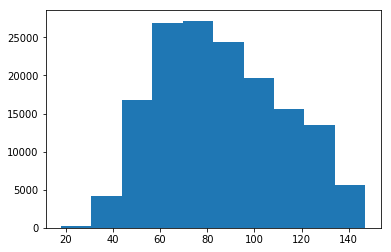

In [46]:
plt.hist(injury_dlen)

In [47]:
labels = np.array(data['event'])

In [48]:
events = sorted(set(labels))

(array([14429.,     0.,   381.,  4648.,  1234.,     0.,  1562., 22559.,
           52.,  4877., 11678., 42498.,  7362., 32085.,  8318.,   900.,
            0.,     0.,     0.,  1373.]),
 array([10.  , 14.45, 18.9 , 23.35, 27.8 , 32.25, 36.7 , 41.15, 45.6 ,
        50.05, 54.5 , 58.95, 63.4 , 67.85, 72.3 , 76.75, 81.2 , 85.65,
        90.1 , 94.55, 99.  ]),
 <a list of 20 Patch objects>)

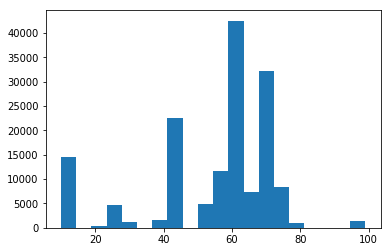

In [49]:
plt.hist(labels, bins=20)

Let's build vocabulary dictionaries for the words in the incident descriptions.

In [50]:
id2word = {}
word2id = {}
index = 0
for line in injury_desc:
    tokens = line.split(" ")
    for t in tokens:
        if t not in word2id:
            word2id[t] = index
            id2word[index] = t
            index += 1

In [111]:
len(id2word)

18987

In [112]:
incident_tokens = {}
for index, text in enumerate(injury_desc):
    incident = labels[index]
    if incident not in incident_tokens:
        incident_tokens[incident] = []
    tokens = text.split(" ")
    for t in tokens:
        if t not in incident_tokens[incident]:
            incident_tokens[incident].append(t)

In [113]:
incident_tokens[10]

['51',
 'year',
 'old',
 'male',
 'pain',
 'to',
 'l',
 '5th',
 'finger',
 'when',
 'responding',
 'a',
 'situation',
 'at',
 'work',
 'and',
 'broke',
 'out',
 'inri',
 'fx',
 '30',
 'wrestling',
 'w',
 'another',
 'person',
 'weights',
 '300',
 'landed',
 'on',
 'hand',
 'all',
 'occured',
 'dx',
 'sprain',
 'low',
 'back']

In [114]:
for ev in events:
    print("Words for event {}: {}".format(ev, len(incident_tokens[ev])))

Words for event 10: 36
Words for event 11: 4759
Words for event 12: 2533
Words for event 13: 3165
Words for event 20: 120
Words for event 21: 265
Words for event 22: 340
Words for event 23: 749
Words for event 24: 1509
Words for event 25: 486
Words for event 26: 2398
Words for event 27: 1716
Words for event 29: 14
Words for event 30: 26
Words for event 31: 1729
Words for event 32: 1092
Words for event 40: 315
Words for event 41: 1616
Words for event 42: 5497
Words for event 43: 3763
Words for event 44: 899
Words for event 45: 185
Words for event 49: 260
Words for event 50: 239
Words for event 51: 1351
Words for event 52: 984
Words for event 53: 3363
Words for event 54: 128
Words for event 55: 6791
Words for event 56: 91
Words for event 59: 72
Words for event 60: 3903
Words for event 61: 317
Words for event 62: 7713
Words for event 63: 4673
Words for event 64: 3159
Words for event 65: 345
Words for event 66: 2302
Words for event 67: 410
Words for event 69: 583
Words for event 70: 3543
W

In [22]:
word_count_by_cat = {}
for word in id2word.values():
    word_count_by_cat[word] = 0
    for cat in events:
        if word in incident_tokens[cat]:
            word_count_by_cat[word] += 1

In [23]:
word_dist = [count for count in word_count_by_cat.values()]

(array([3.0724e+04, 2.3120e+03, 9.0200e+02, 7.0200e+02, 3.5300e+02,
        3.0600e+02, 2.0000e+02, 6.8000e+01, 4.5000e+01, 2.0000e+01]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ]),
 <a list of 10 Patch objects>)

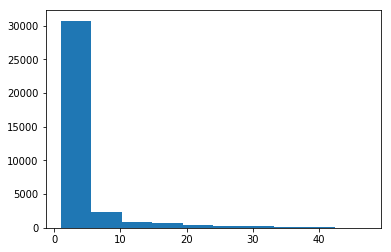

In [24]:
plt.hist(word_dist)

In [51]:
data.head()

,text,sex,age,event
0,57 yom with contusion to face after striking i...,1,57,62
1,a 45 yom fell on arm while working had slipped...,1,45,42
2,58 yom with cervical strain back pain s p rest...,1,58,26
3,33 yom lac to hand from a razor knife,1,33,60
4,53 yom at work in a warehouse doing unspecifie...,1,53,71


In [52]:
data.to_csv("/home/vijjus/datasets/cdc_train_fixed.csv")